<a href="https://colab.research.google.com/github/flowykk/fin-markets/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Методы Монте-Карло (ДЗ 4)

In [1]:
#all imports here, please
import numpy as np
from scipy.special import sinc
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании мы на практике поразбираемся, как можно использовать методы Монте-Карло для вычисления интегралов. Позади этой идеи целая наука, достойная отдельного курса, которую мы не в силах покрыть 1 неделей.

## Посчитать не вычислимый аналитически интеграл, 2.5 балла

Положим, мы хотим вычислить

$$
\int_{a}^b f(x) dx,
$$

который мы не можем посчитать руками (либо мы недостаточно искусны). В рамках одно(двух,трёх)мерного случая есть квадратурные формулы (например, метод трапеций),  но что делать, если мы хотим посчитать 100-мерный интеграл? В этом случае помогают методы Монте-Карло. Для простой иллюстрации мы ограничимся одномерным интегралом, но вы сможете при желании разобраться, как можно обобщить.

Усиленный закон больших чисел говорит, если дана последовательность незавсимых и одинаково распределённых величин с конечной диспресией $(\xi_n)$, то

$$
\frac{1}{n}\sum_{i=1}^n \xi_i \to_{\text{п.н.}}\mathbb{E}[\xi_1].
$$

Если мы сможем представить искомый интеграл как матожидание некоторой случайной величины, которую мы дёшево можем семплировать, то мы можем использовать УЗБЧ, для того чтобы приближённо посчитать интеграл, причём скорость сходимости ($1/\sqrt{n}$) не зависит даже от размерности $x$.

### Равномерное распределение

Плотность равномерного распределения на отрезке $[a,b]$ известна. Давайте присмотримся к интегралу:

$$
\int_{a}^b f(x) dx = \frac{b-a}{b-a}\int_{a}^b f(x) dx = (b-a) \mathbb{E}[f(U)], \quad U \sim Uniform([a,b]).
$$

На основе этого можно предложить метод.

#### Метод интегрирования на основе равномерного распределения (0.5 балла)

Реализуйте метод интегрирования, используя библиотеку numpy.


In [12]:
def uniformMC(func, a, b, n):
    '''
    Вычисляет интеграл от функции func по промежутку [a,b], используя метод Монте-Карло с равномерныи распределением

    Параметры
    ---------------
    funcHandler func -- функция  f: R -> R
    float a -- левая граница
    float b -- правая граница
    int n -- количество семплов

    Возвращает
    -----------
    float est
    '''
    x = np.random.uniform(a, b, n)
    y = func(x)
    return (b - a) * np.mean(y)


def f(x):
    return x**2

In [13]:
# простой пример для самопроверки
a=0
b=2
ns = np.arange(10,1e7,50000).astype("int64")
intTrue = 8/3 # вычислите истинный интеграл

res = np.zeros([len(ns)])
for i in tqdm.tqdm(np.arange(len(ns))):#обёртка tqdm, чтобы рисовать прелоадер
    res[i]=uniformMC(f,a,b,ns[i])

100%|██████████| 200/200 [00:18<00:00, 10.95it/s]


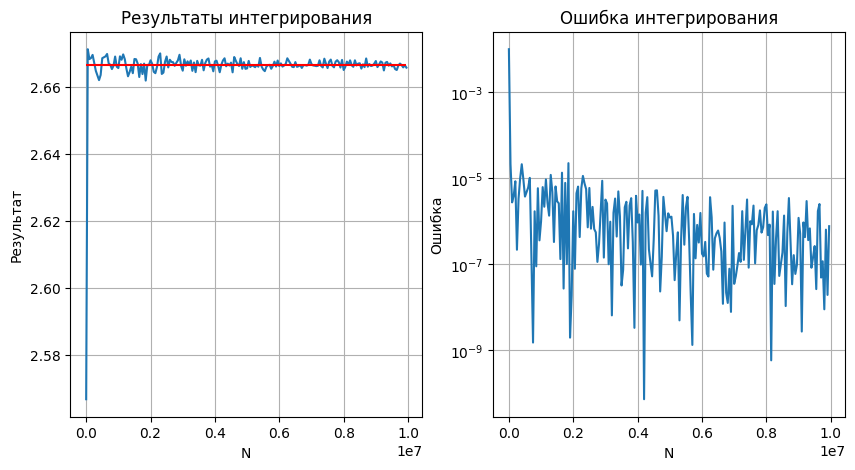

In [14]:
#сопоставим с известным для самопроверки

f, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))

ax.set_title("Результаты интегрирования")
ax.set_xlabel("N")
ax.set_ylabel("Результат")
#ax.set_yscale("log")#для лучшей различимости быстро убывающих вещей
ax.grid()

ax.plot(ns,res)
ax.hlines(y=intTrue,xmin=ns[0],xmax=ns[-1], colors="red")


ax2.set_title("Ошибка интегрирования")
ax2.set_xlabel("N")
ax2.set_ylabel("Ошибка")
ax2.set_yscale("log")#для лучшей различимости быстро убывающих вещей
#ax2.set_xscale("log")#для лучшей различимости быстро убывающих или растущих вещей
ax2.grid()

ax2.plot(ns,(res-intTrue)**2)

Вроде работает, если у вас сходится до ошибки $10^{-7}$.

### Скорость сходимости (0.3 балла)

Какая скорость сходимости? Попробуйте посчитать сами, предположив, что ошибка
$$
Err_n = cn^p + \varepsilon_n,
$$
и оценив $p$ по данным, используя метод наименьших квадратов. Подсказка: возьмите логарифм от левой и правой части, а потом методом наименьших квадратов оцените коэффициент при $\ln n$. Нарисуйте рядом с ошибками линию $f(n) = cn^p$, используя оценённые значения.

Для этого вам понадобится, например, np.linalg.lstsq.

In [15]:
lners = np.log(np.array((res-intTrue)**2))
lnns = np.log(ns)

#соберите матрицу для lstsq
# [logN, 1]... например, шейпа (200,2) (первая размерность -- количество ns, которые вы взяли выше)
a = np.vstack([lnns, np.ones_like(lnns)]).T

alpha = np.linalg.lstsq(a, lners, rcond=None)[0]

Модель logErr_n = -0.8025887633566774log(n) + -2.402385725304406


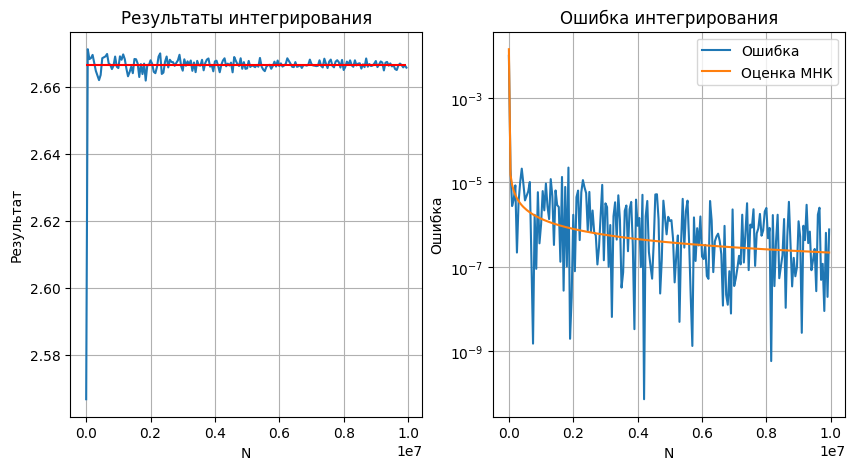

In [16]:
#сопоставим с известным для самопроверки

f, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))

ax.set_title("Результаты интегрирования")
ax.set_xlabel("N")
ax.set_ylabel("Результат")
#ax.set_yscale("log")#для лучшей различимости быстро убывающих вещей
ax.grid()

ax.plot(ns,res)
ax.hlines(y=intTrue,xmin=ns[0],xmax=ns[-1], colors="red")


ax2.set_title("Ошибка интегрирования")
ax2.set_xlabel("N")
ax2.set_ylabel("Ошибка")
ax2.set_yscale("log")#для лучшей различимости быстро убывающих вещей
#ax2.set_xscale("log")#для лучшей различимости быстро убывающих или растущих вещей
ax2.grid()

ax2.plot(ns,(res-intTrue)**2)
print(f"Модель logErr_n = {alpha[0]}log(n) + {alpha[1]}")
ax2.plot(ns,np.exp(alpha[1])*ns**alpha[0])
ax2.legend(["Ошибка", "Оценка МНК"])

Напишите, чему равно оценённое $p$ (скорость сходимости) и поясните свой ответ.

Оценённое p - коэффициент при log(n).

Значит p = -0.8025887633566774

#### Верхняя оценка для ошибки (0.5 балла)

Мы можем использовать известные нам предельные законы вместе с некоторыми обычными неравенствами, чтобы получить оценки для ожидаемой ошибки, например, в форме
$$
\mathbb{E}[(I_n - I)^2] = \mathbb{E}\left[\left( (b-a)\frac{1}{n}\sum_{i=1}^n f(X_i) - \int_{a}^b f(x) dx\right)^2\right].
$$
На языке вероятности выглядит очень компактно.

Докажите, что
$$
\mathbb{E}[(I_n - I)^2] = \frac{D[f(X)]}{n}, ~ X \sim Uniform[a,b].
$$

Учтём, что данные величины $X_1, \dots, X_n$ одинаково распределенны, то есть $X_n \sim Uniform[a, b]$

$\mathbb{E}[(I_n] = \mathbb{E}\left[(b-a)\dfrac{1}{n}\sum_{i=1}^n f(X_i)^2\right] = \dfrac{b-a}{n} \cdot \mathbb{E}\left[\sum_{i=1}^n f(X_i)\right] = \dfrac{b-a}{n} \cdot \sum_{i=1}^n \mathbb{E}\left[f(X_i)\right] = \dfrac{b-a}{n} \cdot n \cdot \mathbb{E}[f(X)] = (b - a) \cdot \mathbb{E}[f(X)]$

Мы можем также посчитать интеграл $I$, тогда получим:

$I = \int_a^b f(x) dx = (b-a) \cdot \int_a^b \dfrac{1}{b-a}f(x)dx = (b-a) \cdot \mathbb{E}[f(X)]$

Теперь:

$E[(I_n-I)^2] = E[(I_n-E[I_n])^2] = D[I_n]$

Учитывая это и то, что величины $X_1, \dots, X_n$ независимые:

$\mathbb{D} \left[(b-a) \cdot \dfrac{1}{n} \cdot \sum_{i=1}^n f(X_i)\right] = \dfrac{(b-a)^2}{n^2} \cdot \mathbb{D} [\sum_{i=1}^n f(X_i)] = \dfrac{(b-a)^2}{n^2} \cdot \sum_{i=1}^{n}\mathbb{D}[f(X_i)] = \dfrac{(b-a)^2}{n^2} \cdot n \cdot \mathbb{D} [f(X)]$ = $ = \dfrac{(b-a)^2}{n} \cdot \mathbb{D}[f(X)]$

Получили, что $E[(I_n-I)^2] = \dfrac{(b-a)^2}{n} \cdot \mathbb{D}[f(X)]$

Ч.Т.Д.

#### Вероятностная оценка для ошибки (0.5 балла)

С другой стороны, центральная предельная теорема позволяет найти асимптотическое распределение $I_n$. Напишите, какое распределение при больших $n$ будет иметь $I_n$ и найдите вероятность $\mathbb{P}(\vert I_n \vert<\varepsilon)$; напишите, как её посчитать для любых $n,\varepsilon$.

ВАШИ ВЫКЛАДКИ ЗДЕСЬ

Напишите, как подобрать $\varepsilon$, чтобы вероятность $\mathbb{P}(\vert I_n \vert<\varepsilon)=p$, где $p$ вы задаёте сами в интервале от 0 до 1. Подсказка: вспомните, что такое квантиль.

ВАШ ОТВЕТ ЗДЕСЬ

#### Расчёты для разных функций (0.7 балла)

Исходя из своего номера в ведомости выберите себе функцию, считая остаток от деления вашего id на количество задач и прибавив +1. Посчитайте интеграл для всех $n$ от $10^3$ до $5*10^6$ c шагом $50000$, нарисуйте график ошибки $(I_n-I)^2$ в логарифмических осях, а также вычислите эмпирически скорость сходимости (как выше). Приведите

1. Что-то привычное
$$
1) f(x)= x^{1/5} sin(0.8x-2) + 25x, ~a=3, b=15
$$
$$
2) f(x)= e^{0.3x+0.002x^4}cos(0.7x) - 3x^2 + 4, ~a=3, b=5
$$
$$
3) f(x)= e^{0.3x} + 4 e^{-x^2/4}x^3 + 4, ~a=3, b=10
$$
$$
4) f(x)= e^{0.3x} + 4 e^{-x^2/4}x^3 + 4, ~a=2, b=6
$$
$$
5) f(x)= e^{-0.8x + 4cos^2(x)} + 2 e^{-x^2/4}x^2 - 3, ~a=1, b=5
$$
2. Что-то менее очевидное (вам понадобится модуль scipy.special, за математикой см. [sinc](https://en.wikipedia.org/wiki/Sinc_function), [Si](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%82%D0%B5%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D1%81%D0%B8%D0%BD%D1%83%D1%81),  [Ci](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%82%D0%B5%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%BA%D0%BE%D1%81%D0%B8%D0%BD%D1%83%D1%81), [функции Бесселя](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F) )
$$
1) f(x) = sinc(x)cos(5x)x^3, ~ a=0.2, b=2
$$
$$
2) f(x) = Si(x)cos(2x)x^3, ~ a=0.2, b=2
$$
$$
3) f(x) = Сi(x)sin(3x)x^3, ~ a=0.2, b=3
$$
$$
4) f(x) = J_{0}(x)cos(3x)e^{2x}, ~ a=0.2, b=4
$$
$$
5) f(x) = J_{1}(x)sin(6x)e^{-0.1x}, ~ a=0.2, b=4
$$

Номер в ведомости - 25

Номер функции: 25 % 5 + 1 = 1

In [11]:
def uniformMC(func, a, b, n):
    x = np.random.uniform(a, b, n)
    y = func(x)
    return (b - a) * np.mean(y)

def f1(x):
    return (x**(1/5))*np.sin(0.8*x - 2) + 25*x

def f2(x):
    return np.sinc(x)*np.cos(5*x)*(x**3)

print("integral for usual func:")
for n in range(10**3, 5*10**6 + 1, 50000):
    print("Integral =", uniformMC(f1, 3, 15, n), ", with n =", n)

print("integral for unusual func:")
for n in range(10**3, 5*10**6 + 1, 50000):
    print("Integral =", uniformMC(f2, 0.2, 4, n), ", with n =", n)


integral for usual func:
Integral = 2719.1232436578957 , with n = 1000
Integral = 2700.8150196630722 , with n = 51000
Integral = 2709.1618391390243 , with n = 101000
Integral = 2696.5036780687337 , with n = 151000
Integral = 2700.5702031052792 , with n = 201000
Integral = 2700.7677446128155 , with n = 251000
Integral = 2699.9630647913336 , with n = 301000
Integral = 2704.338540213469 , with n = 351000
Integral = 2701.308467851312 , with n = 401000
Integral = 2704.179392340957 , with n = 451000
Integral = 2705.832665316338 , with n = 501000
Integral = 2704.1974287058692 , with n = 551000
Integral = 2701.594607406089 , with n = 601000
Integral = 2704.0844388482797 , with n = 651000
Integral = 2703.206330330118 , with n = 701000
Integral = 2704.8737906239967 , with n = 751000
Integral = 2704.006054479933 , with n = 801000
Integral = 2703.5091068400343 , with n = 851000
Integral = 2702.492578586966 , with n = 901000
Integral = 2704.3768196888295 , with n = 951000
Integral = 2703.1141845557